# Behavioral Cloning With MXNet

This notebook walks through how we can create a model to predict the streeting angle from an image captured through the Pi camera of a robocar. For details on how to build the car itself visit www.donkeycar.com

The images have been captured data from the camera mounted over the car. Each image is captured with the the throttle data and the steering angle. We construct a Convolutional Neural Network (CNN) to mimic the behavior of the training data and predict the steering angle given an image.


# Download the RecordIO files which have the image data

For ease of use I have already converted the image dataset with labels in to MXNet RecordIO format and split in to train and test sets

In [ ]:
!wget https://s3.amazonaws.com/smallya-test/mxnet-behavioral-cloning/train.rec

!wget https://s3.amazonaws.com/smallya-test/mxnet-behavioral-cloning/valid.rec

In [ ]:
# Images are available @
https://s3.amazonaws.com/smallya-test/mxnet-behavioral-cloning/trainingdata

In [89]:
import mxnet as mx
import numpy as np

import logging
head = '%(asctime)-15s %(message)s'
logging.basicConfig(level=logging.DEBUG, format=head)

#load 
def get_iterators(batch_size, data_shape=(3, 120, 160)):
    train = mx.io.ImageRecordIter(
        path_imgrec         = 'train.rec', 
        data_name           = 'data',
        label_name          = 'softmax_label',
        batch_size          = batch_size,
        data_shape          = data_shape,
        shuffle             = True,
        rand_crop           = True,
        rand_mirror         = True)
    val = mx.io.ImageRecordIter(
        path_imgrec         = 'valid.rec',
        data_name           = 'data',
        label_name          = 'softmax_label',
        batch_size          = batch_size,
        data_shape          = data_shape,
        rand_crop           = False,
        rand_mirror         = False)
    return (train, val)

batch_size = 16
train_iter, val_iter = get_iterators(batch_size)

# Define the model

In [103]:
data = mx.symbol.Variable(name="data")

body = mx.sym.Convolution(data=data, num_filter=24,  kernel=(5, 5), stride=(2,2), no_bias=True, name="conv1")
body = mx.sym.Activation(data=body, act_type='relu', name='relu1')
body = mx.symbol.Pooling(data=body, kernel=(2, 2), stride=(2,2), pool_type='max')

body = mx.sym.Convolution(data=body, num_filter=32,  kernel=(5, 5), stride=(2,2))
body = mx.sym.Activation(data=body, act_type='relu')
body = mx.symbol.Pooling(data=body, kernel=(2, 2), stride=(2,2), pool_type='max')

flatten = mx.symbol.Flatten(data=body)

body = mx.symbol.FullyConnected(data=flatten, name='fc0', num_hidden=32)
body = mx.sym.Activation(data=body, act_type='relu', name='relu6')
body = mx.sym.Dropout(data=body, p=0.1)

body = mx.symbol.FullyConnected(data=body, name='fc1', num_hidden=16)
body = mx.sym.Activation(data=body, act_type='relu', name='relu7')

out = mx.symbol.FullyConnected(data=body, name='fc2', num_hidden=1)
out = mx.symbol.LinearRegressionOutput(data=out, name="softmax")

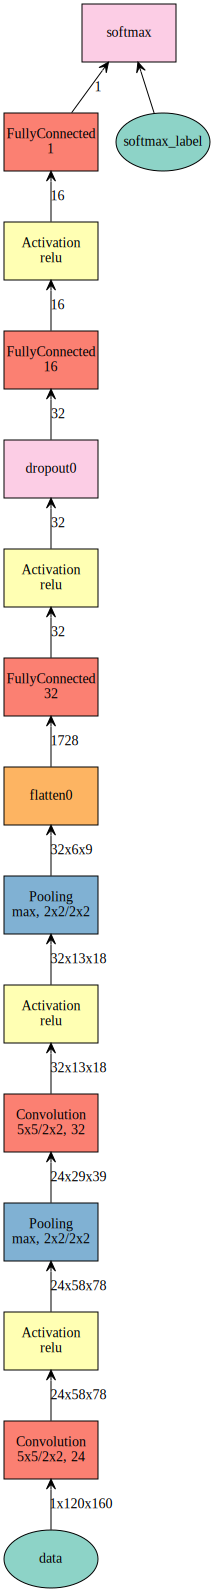

In [104]:
#(batch_size, NUM_CHANNELS, HEIGHT, WIDTH)
shape = {"data" : (16, 1, 120, 160)}
mx.viz.plot_network(symbol=out, shape=shape)

In [107]:
### 2. build a basic model

batch_size = 8
num_gpus = 1
num_epoch = 10
mod = mx.mod.Module(out, context=[mx.gpu(i) for i in range(num_gpus)])
mod.fit(train_data=train_iter, 
        eval_data=val_iter, 
        eval_metric='mae', 
        optimizer='adam',
        optimizer_params={'learning_rate': 0.0001},
        num_epoch=num_epoch,
        batch_end_callback = mx.callback.Speedometer(batch_size, 100),        
       )

2017-10-27 16:47:02,378 Epoch[0] Batch [100]	Speed: 1360.83 samples/sec	mae=0.181732
2017-10-27 16:47:02,714 Epoch[0] Batch [200]	Speed: 2385.85 samples/sec	mae=0.170571
2017-10-27 16:47:03,238 Epoch[0] Batch [300]	Speed: 1530.14 samples/sec	mae=0.172682
2017-10-27 16:47:03,529 Epoch[0] Batch [400]	Speed: 2765.72 samples/sec	mae=0.175305
2017-10-27 16:47:03,693 Epoch[0] Train-mae=0.167332
2017-10-27 16:47:03,695 Epoch[0] Time cost=1.908
2017-10-27 16:47:03,801 Epoch[0] Validation-mae=0.162942
2017-10-27 16:47:04,374 Epoch[1] Batch [100]	Speed: 2780.09 samples/sec	mae=0.172052
2017-10-27 16:47:04,893 Epoch[1] Batch [200]	Speed: 1546.00 samples/sec	mae=0.161858
2017-10-27 16:47:05,198 Epoch[1] Batch [300]	Speed: 2633.10 samples/sec	mae=0.154383
2017-10-27 16:47:05,730 Epoch[1] Batch [400]	Speed: 1506.50 samples/sec	mae=0.149893
2017-10-27 16:47:06,021 Epoch[1] Batch [500]	Speed: 2762.78 samples/sec	mae=0.139448
2017-10-27 16:47:06,537 Epoch[1] Batch [600]	Speed: 1553.66 samples/sec	mae=0

In [ ]:
CNN1

2017-10-26 16:16:12,103 Epoch[9] Train-mae=0.134811
2017-10-26 16:16:12,104 Epoch[9] Time cost=5.361
2017-10-26 16:16:12,320 Epoch[9] Validation-mae=0.130831
        
        
CNN2 : adam : 0.0001: batch_size = 16

2017-10-26 16:21:03,409 Epoch[19] Train-mae=0.098656
2017-10-26 16:21:03,410 Epoch[19] Time cost=3.349
2017-10-26 16:21:03,548 Epoch[19] Validation-mae=0.101364

In [ ]:
# Save the model
prefix = 'my-car'
mc = mod.save_checkpoint(prefix, num_epoch)

In [2]:
# Helper function to convert iterator to list for augmenting data

def iter_to_ndarray(data_iter):
    '''
    @ returns data array and label array
    '''
    data_iter.reset()

    from collections import namedtuple
    Batch = namedtuple('Batch', ['data'])

    data = []
    labels = []
    
    for it in enumerate(val_iter):
        for datum, l in zip(it[1].data[0], it[1].label[0]):
            data.append(datum)
            labels.append(l)
    return data, labels

In [4]:
tx, ty = iter_to_ndarray(val_iter)

In [110]:
# Load the model ;  
num_epoch = 30
sym, arg_params, aux_params = mx.model.load_checkpoint('my-car', num_epoch)
mod = mx.mod.Module(symbol=sym)

In [112]:
# Testing the model
from PIL import Image
import numpy as np

dshape = [('data', (1,3,120,160))]
mod.bind(for_training=False, data_shapes=dshape)
mod.set_params(arg_params, aux_params)

expect: 0.11115, pred: 0.30511, diff: -0.19397
expect: 0.10741, pred: 0.20214, diff: -0.09473
expect: -0.06599, pred: -0.13128, diff: 0.06529


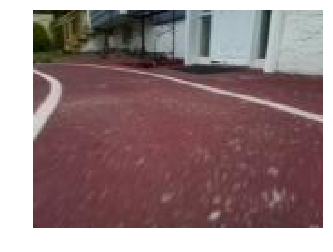

In [113]:
import numpy as np
from PIL import Image
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

import cv2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

imgs = [
        'frame_00135_ttl_0.2479085339356424_agl_0.11114842857855993_mil_0.0.jpg',
        'frame_00126_ttl_0.25_agl_0.10740846691566244_mil_0.0.jpg',
        'frame_00140_ttl_0.25_agl_-0.06599178170093933_mil_0.0.jpg'
       ]

path = "./trainingdata/"

for i in range(len(imgs)):
    
    img_loc = path + imgs[i]
    
    # pre process image
    img = Image.open(img_loc)
    img = np.array(img)
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2) 
    img = img[np.newaxis, :] 

    mod.forward(Batch(data=[mx.nd.array(img)]))
    angle = mod.get_outputs()[0].asnumpy()[0]
    exp = float(imgs[i].split('_')[5])
    diff = exp - angle[0]
    print "expect: %.5f, pred: %.5f, diff: %.5f" %(exp , angle[0], diff)
    
    img = cv2.imread(img_loc)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

## Lets build a Simulatior

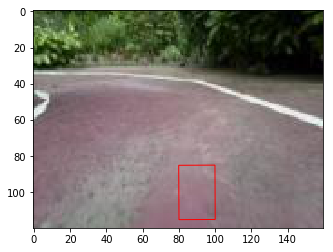

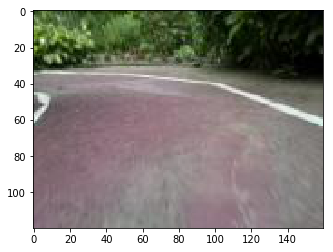

In [116]:
import os

import time
%matplotlib inline
from IPython import display

PATH = 'trainingdata/'
all_files = sorted(os.listdir(PATH))

fig, ax = plt.subplots(1)
for fname in all_files[70:200]:
    org_img = Image.open(PATH + fname)    
    img = np.array(org_img)
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2) 
    img = img[np.newaxis, :] 

    mod.forward(Batch(data=[mx.nd.array(img)]))
    exp = mod.get_outputs()[0].asnumpy()[0]
    
    #exp = float(fname.split('_')[5])
    angle = 180*exp
    left = 80 * exp + 80
    rect = patches.Rectangle((left, 85),20,30, angle=angle,
                             linewidth=1,edgecolor='r',facecolor='none')
    patch = ax.add_patch(rect)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.imshow(org_img)
    time.sleep(0.1)
    patch.remove()

For more info on the topic: https://medium.com/@ksakmann/behavioral-cloning-make-a-car-drive-like-yourself-dc6021152713

In [ ]:
# Extract images out of the iterator

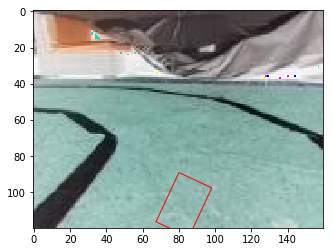

In [54]:
#test

import numpy as np
from PIL import Image
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

import cv2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# pre process image
img = tx[2].asnumpy()
print img.shape
#img = np.swapaxes(img, 0, 2)
#img = np.swapaxes(img, 1, 2) 
img = img[np.newaxis, :] 
print img.shape

mod.forward(Batch(data=[mx.nd.array(img)]))
angle = mod.get_outputs()[0].asnumpy()[0]
print angle 

import matplotlib.patches as patches

img = tx[1].asnumpy()
img = np.swapaxes(img, 2, 0)
img = np.swapaxes(img, 0, 1) 
#img = np.swapaxes(img, 2, 1) 

img.shape

fig, ax = plt.subplots(1)
ax.imshow(img)
rect = patches.Rectangle((80,89),20,30, angle=25, linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.imshow(img)